# Entrenamiento de modelos binarios.

Este notebook tiene como objetivo entrenar los mismos modelos pero sólo orientados a predecir noticias de dos clases: Falsas y verdaderas (En vez de multiples clases).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --upgrade pandas

#!pip install talos
#!pip install statsmodels -U
#!pip install --upgrade pytest

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.2)


In [3]:
!ls "drive/My Drive/Colab Notebooks/data"

data_kaggle_proc.pickle		       news_getting_real.pickle
GoogleNews-vectors-negative300.bin.gz  news_proc_12_3_19.pickle
news_getting_real2.pickle


# Imports, loads , Train/test split and Optimum params
---

In [0]:
import pandas as pd
import numpy as np

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
#import swifter

from matplotlib import pyplot as plt
from matplotlib import style
#Nicer style
style.use('seaborn')
import seaborn as sns

from tensorflow import keras as k

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [0]:
data = pd.read_pickle('drive/My Drive/Colab Notebooks/data/news_proc_12_3_19.pickle')#.reset_index()
data = data.dropna()

Labels asignadas a los tipos

In [6]:
types = data['type'].unique()
for t in types:
    print("{} - {}".format(t, data[data['type'] == t].head(1)['one_hot_label'].iloc[0]))

bias - [1 0 0 0]
click - [0 1 0 0]
fake - [0 0 1 0]
truth - [0 0 0 1]


Convertir a FAKE todo lo que no sea TRUE



In [0]:
data['label'] = data.apply(lambda r: 1 if r['one_hot_label'][-1] == 1 else 0,axis=1)

In [8]:
len_content = len(data['content'][0])
len_title = len(data['title'][0])

print("Max len content: {}".format(len_content))
print("Max len title: {}".format(len_title))

Max len content: 1598
Max len title: 13


In [0]:
model = KeyedVectors.load_word2vec_format("drive/My Drive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin.gz", binary=True, limit=50000)

In [0]:
embed_mat = np.zeros((50000,300))
for i, e in model.vocab.items():
    embed_mat[e.index] = model[i]

**Tran/valid/test split**

In [0]:
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
    data[['content', 'title']], data['label'], test_size=0.3, random_state=1)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=1)

In [0]:
X_train_title = X_train['title']
X_train_content = X_train['content']

X_valid_title = X_valid['title']
X_valid_content = X_valid['content']

X_test_title = X_test['title']
X_test_content = X_test['content']

In [0]:
train_fit = [np.asarray(X_train_title.tolist()), 
             np.asarray(X_train_content.tolist())]

valid_fit = [np.asarray(X_valid_title.tolist()), 
             np.asarray(X_valid_content.tolist())]

test_fit = [np.asarray(X_test_title.tolist()), 
             np.asarray(X_test_content.tolist())]

In [0]:
del data
del X_train_title, X_train_content
del X_valid_title, X_valid_content
del X_test_title, X_test_content

## Optimum Params found with Bayesian Optimization

In [0]:
# Optimum params for LSTM network
params_lstm = {
    'lr': 0.2639850638741692,
    'momentum': 0.08255873365806747,
    'dropout': 0.10591561319817788,
    'dense1': 73,
    'dense2': 24,
    'lstmTitle': 46,
    'lstmContent': 231
}


#Optimum params for CNN network
params_cnn = {
    'lr': 0.23993334664040306,
    'momentum': 0.30361299021107185,
    'dropout1': 0.10993063833594595,
    'dropout2': 0.1586041045258562,
    'filters1Title': 8,
    'denseTitle': 42,
    'filtersContent': 6,
    'denseContent': 34
}

In [0]:
#Some imports...
import tensorflow as tf
import os

from numpy.random import seed
from tensorflow import set_random_seed

# LSTM

In [0]:
seed(50)
set_random_seed(50)
k.backend.clear_session()

In [18]:
#input_title
title_input = k.layers.Input(shape=(len_title,), name='title_input')
inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False)(title_input)
x = k.layers.Bidirectional(k.layers.LSTM(params_lstm['lstmTitle']))(inp)
#CudnnLSTM
#x = k.layers.Bidirectional(k.layers.CuDNNLSTM(params_lstm['lstmTitle']))(inp)

#input_content
content_input = k.layers.Input(shape=(len_content,), name='content_input')
inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False)(content_input)
x2 = k.layers.Bidirectional(k.layers.LSTM(params_lstm['lstmContent']))(inp2)
#CudnnLSTM
#x2 = k.layers.Bidirectional(k.layers.CuDNNLSTM(params_lstm['lstmContent']))(inp2)

#Merge
x = k.layers.concatenate([x, x2])


#Common part
x = k.layers.Dense(params_lstm['dense1'], activation='relu')(x)
x = k.layers.Dropout(params_lstm['dropout'])(x)
x = k.layers.Dense(params_lstm['dense2'], activation='relu')(x)
x = k.layers.Dropout(0.2)(x)

out = k.layers.Dense(1, activation='sigmoid')(x)

#Build model
model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

#model.compile(k.optimizers.SGD(lr=params_lstm['lr'], 
#                               momentum=params_lstm['momentum']), 
#                               loss='categorical_crossentropy', metrics=['acc'])

model.compile(tf.train.MomentumOptimizer(learning_rate=params_lstm['lr'], 
                                         momentum=params_lstm['momentum']), 
                                         loss='binary_crossentropy', metrics=['acc'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        (None, 13)           0                                            
__________________________________________________________________________________________________
content_input (InputLayer)      (None, 1598)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 13, 300)      15000000    title_input[0][0]                
__________________________________________________________________________________________________
embedding_1 (Embeddin

In [19]:
#Optimize TPU

# This address identifies the TPU we'll use when configuring TensorFlow.
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.3.242.170:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 7183336755359095419)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 6598351790351317433)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 14206271102600716933)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint 

In [0]:
#LSTM_CHECKPOINT_PATH = 'drive/My Drive/Colab Notebooks/weights/checkpoint-lstm.h5'
#checkpoint = ModelCheckpoint(LSTM_CHECKPOINT_PATH, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model = tpu_model

In [21]:

hist = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=64*8, epochs=30,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_acc', patience=2, min_delta = 0.01)], 
                 validation_data=(valid_fit, np.array(y_valid.tolist())))

Train on 94319 samples, validate on 40423 samples
Epoch 1/30
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(64,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(64, 13), dtype=tf.float32, name='title_input_10'), TensorSpec(shape=(64, 1598), dtype=tf.float32, name='content_input_10'), TensorSpec(shape=(64, 1), dtype=tf.float32, name='dense_2_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for title_input
INFO:tensorflow:Remapping placeholder for content_input
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 10.908635139465332 secs
INFO:tensorflow:Setting weights on TPU model.
93696/94319 [============================>.] - ETA: 1s - loss: 0.4999 - acc: 0.7628INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(13,

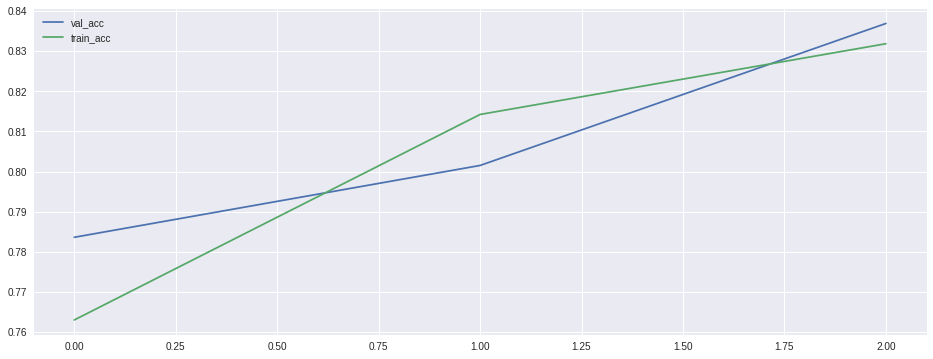

In [22]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['acc'], label='train_acc')
plt.legend()

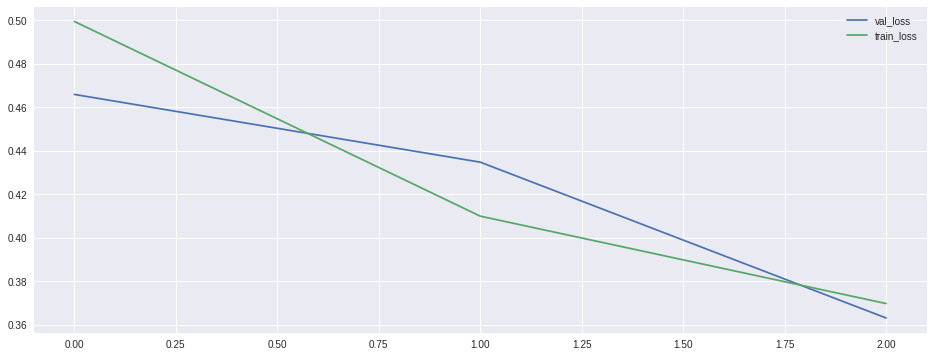

In [23]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='train_loss')
plt.legend()

In [0]:
#model = k.models.load_model(LSTM_CHECKPOINT_PATH)

In [24]:
#For GPU
#test_pred = model.predict(test_fit)

#For TPU
tpu_batch = [test_fit[0][:-3], test_fit[1][:-3]]
test_pred = tpu_model.predict(tpu_batch, batch_size=32*8)

INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(32, 13), dtype=tf.float32, name='title_input_10'), TensorSpec(shape=(32, 1598), dtype=tf.float32, name='content_input_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for title_input
INFO:tensorflow:Remapping placeholder for content_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 29.88983988761902 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(18, 13), dtype=tf.float32, name='title_input_10'), TensorSpec(shape=(18, 1598), dtype=tf.float32, name='content_input_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for title_input
INFO:tensorflow:Remapping placeholder for content_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 21.63938808441162 secs


In [25]:
#accuracy_score(np.array(y_test.tolist()), test_pred.round())
accuracy_score(np.array(y_test.tolist()[:-3]), test_pred.round())

0.8348053477417567

In [26]:
#report = classification_report(np.array(y_test.tolist()), test_pred.round())
report = classification_report(np.array(y_test.tolist()[:-3]), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.84      0.95      0.90     42886
           1       0.78      0.49      0.61     14858

   micro avg       0.83      0.83      0.83     57744
   macro avg       0.81      0.72      0.75     57744
weighted avg       0.83      0.83      0.82     57744



[[40851  2035]
 [ 7504  7354]]


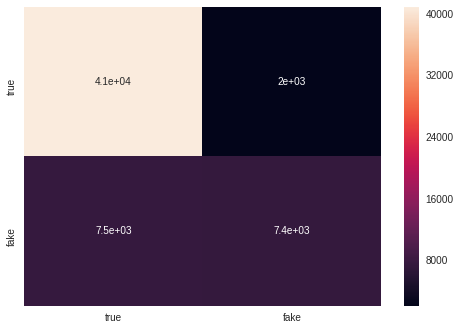

In [29]:
#matrix = confusion_matrix(np.array(y_test.tolist()).argmax(axis=1), test_pred.round().argmax(axis=1))
matrix = confusion_matrix(np.array(y_test.tolist()[:-3]), test_pred.round())
print(matrix)

df_cm = pd.DataFrame(matrix, columns=['true', 'fake'], index=['true', 'fake'])
sns.heatmap(df_cm, annot=True)

In [0]:
from sklearn import metrics

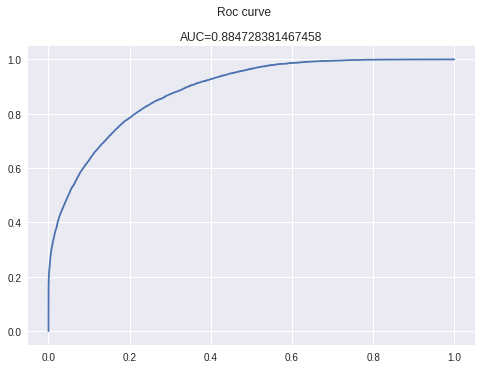

In [33]:
fpr, tpr, thresholds = metrics.roc_curve(y_test[:-3], test_pred)
auc = metrics.roc_auc_score(y_test[:-3], test_pred)

fig,ax = plt.subplots()
ax.set_title('AUC={}'.format(auc))
fig.suptitle('Roc curve')
ax.plot(fpr,tpr)

In [0]:
LSTM_PATH = 'drive/My Drive/Colab Notebooks/weights/lstm-binary.h5'

In [0]:
model.save(LSTM_PATH)

INFO:tensorflow:Copying TPU weights to the CPU


#Redes convolucionales

In [0]:
seed(50)
set_random_seed(50)
k.backend.clear_session()

In [19]:
#input_title
title_input = k.layers.Input(shape=(len_title,), name='title_input')
inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False, name='embed_title')(title_input)

x = k.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
x = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
x = k.layers.Flatten()(x)
x = k.layers.Dense(50, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

#input_content
content_input = k.layers.Input(shape=(len_content,), name='content_input')
inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False, name='embed_content')(content_input)
x2 = k.layers.Conv1D(filters = 40, kernel_size = 16, strides = 2, activation='relu', name='Conv1Content')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool1Content')(x2)

#Added
x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu', name='Conv2Content')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool2Content')(x2)
#

x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)


#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(1, activation='sigmoid')(x)


#Build model
model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

#model.compile(k.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])
#model.compile(k.optimizers.SGD(lr=0.1, momentum = 0.1), loss='categorical_crossentropy', metrics=['acc'])
model.compile(k.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['acc'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        (None, 13)           0                                            
__________________________________________________________________________________________________
content_input (InputLayer)      (None, 1598)         0                                            
__________________________________________________________________________________________________
embed_title (Embedding)         (None, 13, 300)      15000000    title_input[0][0]                
__________________________________________________________________________________________________
embed_content (Embedd

In [0]:
hist = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=128, epochs=20,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.1)], validation_data=(valid_fit, np.array(y_valid.tolist())))

Train on 94319 samples, validate on 40423 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
58368/94319 [=================>............] - ETA: 12:26 - loss: 0.4704 - acc: 0.8247

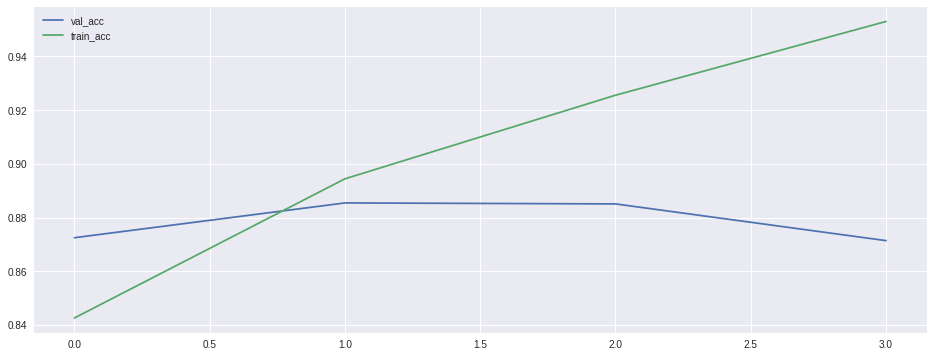

In [21]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['acc'], label='train_acc')
plt.legend()

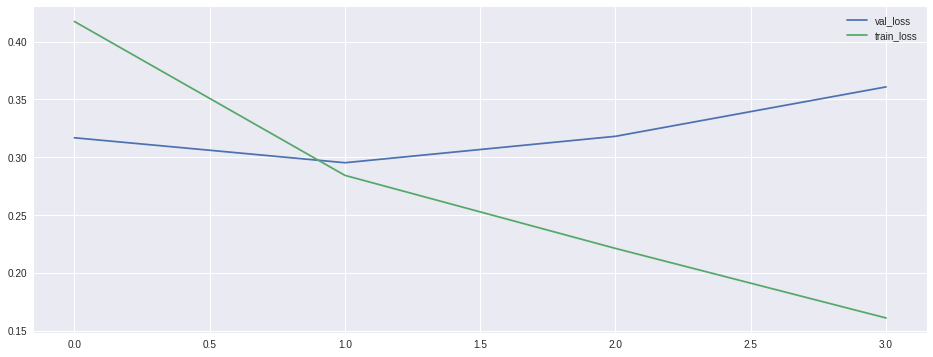

In [22]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_loss'], label='val_loss')
plt.plot(hist.history['loss'], label='train_loss')
plt.legend()

In [23]:
test_pred = model.predict(test_fit)
accuracy_score(np.array(y_test.tolist()), test_pred.round())

0.8734479713231856

In [24]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.95      0.88      0.91     42887
           1       0.71      0.87      0.78     14860

   micro avg       0.87      0.87      0.87     57747
   macro avg       0.83      0.87      0.85     57747
weighted avg       0.89      0.87      0.88     57747



[[37581  5306]
 [ 2002 12858]]


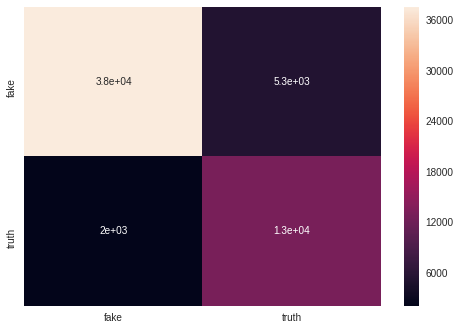

In [25]:
matrix = confusion_matrix(np.array(y_test.tolist()), test_pred.round())
print(matrix)

#Plot
df_cm = pd.DataFrame(matrix, columns=['fake', 'truth'], index=['fake', 'truth'])
sns.heatmap(df_cm, annot=True)

In [0]:
from sklearn import metrics

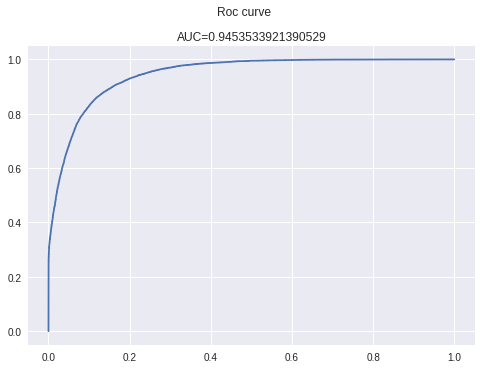

In [38]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
auc = metrics.roc_auc_score(y_test, test_pred)

fig,ax = plt.subplots()
ax.set_title('AUC={}'.format(auc))
fig.suptitle('Roc curve')
ax.plot(fpr,tpr)

In [0]:
CONV_PATH = 'drive/My Drive/Colab Notebooks/weights/conv-binary.h5'
model.save(CONV_PATH)